[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/gist/yhwang17/d58485db8dd6b7e2098825a7c9d43fad/dppm_remd_sciml.ipynb)

#**Denoising Diffusion Probabilistic Model for Replica exchange MD simulation, in Pytorch**

Implementation of <a href="https://arxiv.org/abs/2006.11239">Denoising Diffusion Probabilistic Model</a> for data from replica exchange MD. This implementation was transcribed from the  Tensorflow version <a href="https://github.com/hojonathanho/diffusion">Ho, J., Jain, A. and Abbeel, P., 2020. arXiv:2006.11239.</a> and a modified Pytorch version <a href="https://github.com/lucidrains/denoising-diffusion-pytorch">here</a>. 

This demon mainly consists of three parts:


*   Dataset preparation
*   Training
*   Generate samples



In [1]:
!git clone https://github.com/tiwarylab/DDPM_REMD.git

fatal: destination path 'DDPM_REMD' already exists and is not an empty directory.


In [2]:
!cd DDPM_REMD

In [3]:
!pip3 install einops
!pip3 install pillow
!pip3 install tqdm

In [4]:
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Replica exchange molecular dynamics simulation（REMD）
In REMD, replicas with different temperatures are run in parallel. Attempts to exchange the configurations between replicas are made every certain simulation steps.

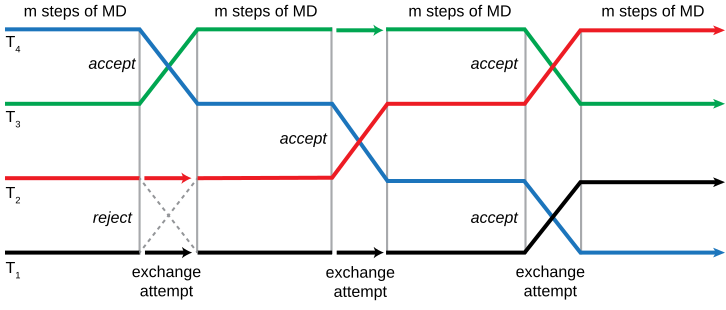

##Denoising Diffusion Probabilistic Model (DDPM)
DDPM learns to reverse a gradual, multi-step noising process that starts with samples generated from the distribution $p(\mathbf{s})$, which we do not have direct access to, and diffuses to the simpler distribution $P_{simple}(\mathbf{s})$ that is easy-to-sample.
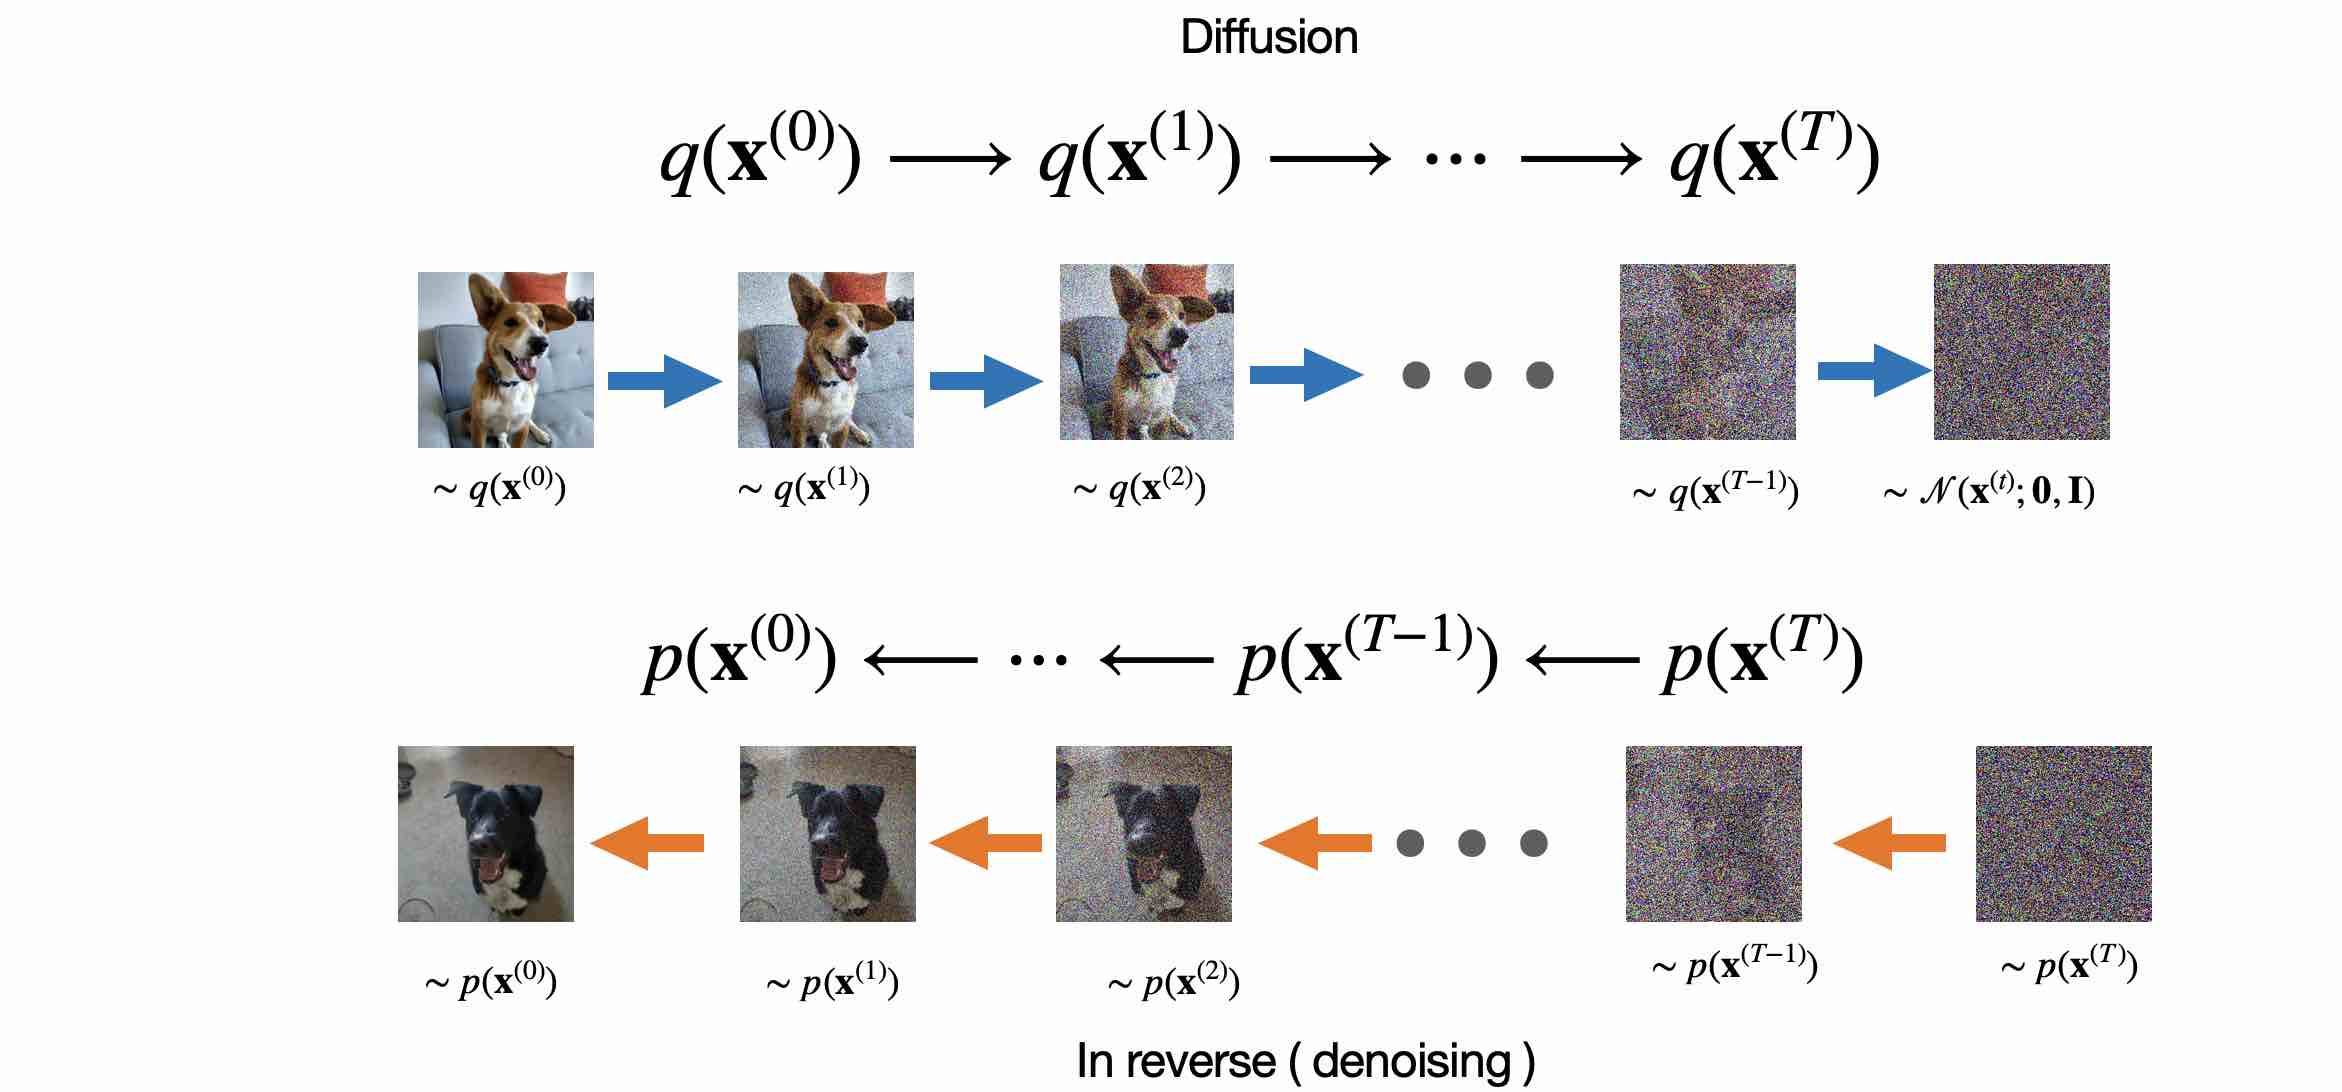


#**Dataset preparation**
Example: AIB9
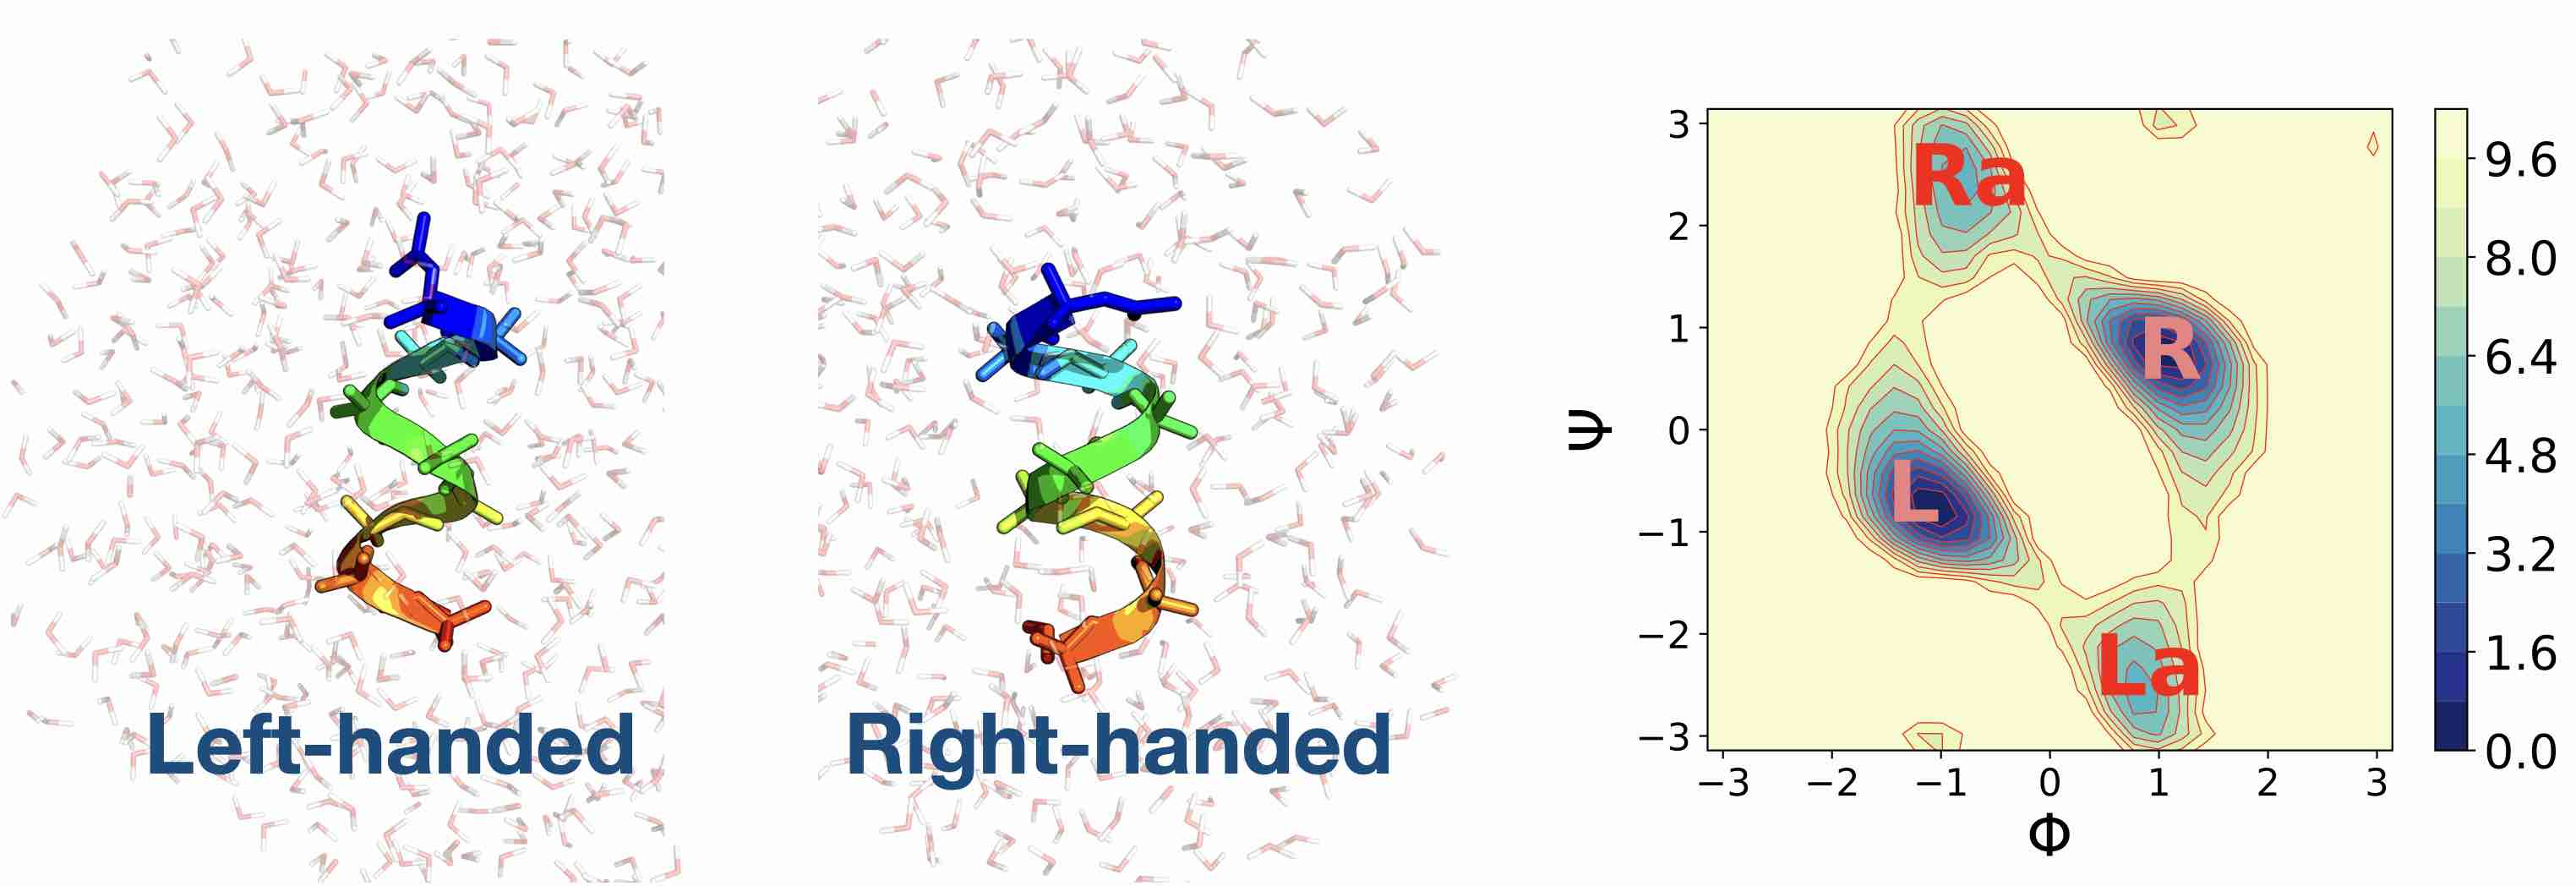

###Task: 
####learn a generator to generate samples from $P(\Phi_1, \Psi_1, \Phi_2, \Psi_2, \cdots \Phi_9, \Psi_9|T)$

In [5]:
training_data = np.load('traj_AIB9/AIB9_REMD_T_full_100000ps_2.0ps_traj.npy') # load the dataset
print(np.shape(training_data))

(500000, 19)


The training data set should be a 2-D array of shape $(n, N_{op}+1)$

$n$ is the number of data points 

$N_{op}$ is the number of order parameters

The first column of the 2-D array should be the instantaneous temperature that derived from its instantaneous kinetic energy.

temperature  | $\Phi_1$ | $\Psi_1$ | $\Phi_2$ | $\Psi_2$  | $\cdots$ | $\Phi_9$ | $\Psi_9$ 
-------------------|------------------|------------------ |------------------|------------------ |------------------|------------------ |------------------
396.1   | 0.76  | -2.19     | -1.29 | -0.76  |  $\cdots$ | -1.39 | -0.66
401.6     |  0.46  | -2.106 | -1.21 | -0.63   |  $\cdots$ | -1.10| -0.85
$\cdots$|$\cdots$|$\cdots$ |$\cdots$|$\cdots$ |$\cdots$|$\cdots$ |$\cdots$

Text(0, 0.5, 'P(T)')

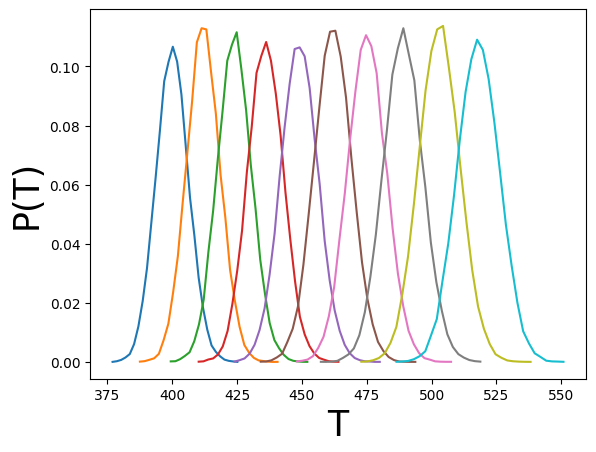

In [6]:
#plot the distribution of instantaneous temperature of each replica
T = training_data[:,0]
n_sample_replica = 50000
n_replica = 10
for j in range(n_replica):
  T = training_data[j*n_sample_replica: (j+1)*n_sample_replica,0]
  his, edges = np.histogram(T, bins= 30)
  his = his/np.sum(his)
  T_x = (edges[1:] + edges[:-1])/2
  plt.plot(T_x, his)
plt.xlabel('T', fontsize = 25)
plt.ylabel('P(T)', fontsize = 25)

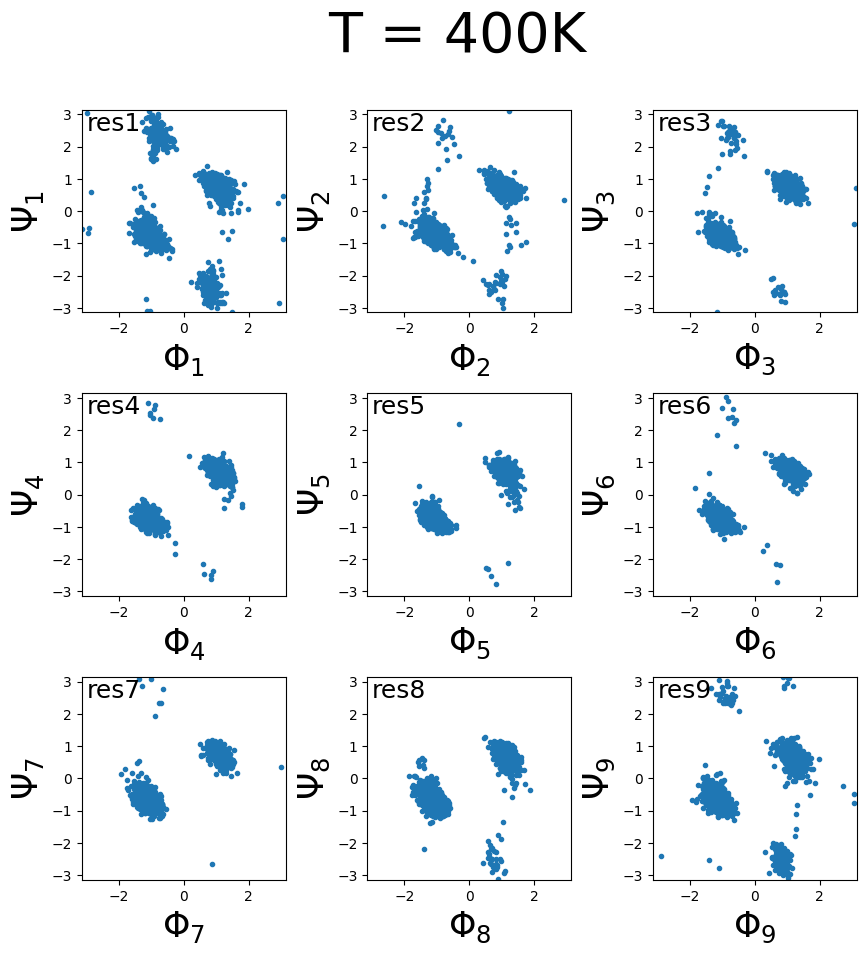

In [7]:
# plt samples from replica with T=400
fig = plt.figure(figsize=(10, 10),frameon=False)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('T = 400K', fontsize=40)
for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i)
    ax.plot(training_data[:n_sample_replica:25, i*2-1], training_data[:n_sample_replica:25, i*2],'.')    
    ax.text(-3, 2.5,  f'res{i}', fontsize = 18)
    ax.set_xlim([-np.pi, np.pi])
    ax.set_ylim([-np.pi, np.pi])
    ax.set_xlabel(r'$\Phi_%i$'%i, fontsize = 25)
    ax.set_ylabel(r'$\Psi_%i$'%i, fontsize = 25)

#**Training**
###network archetecture
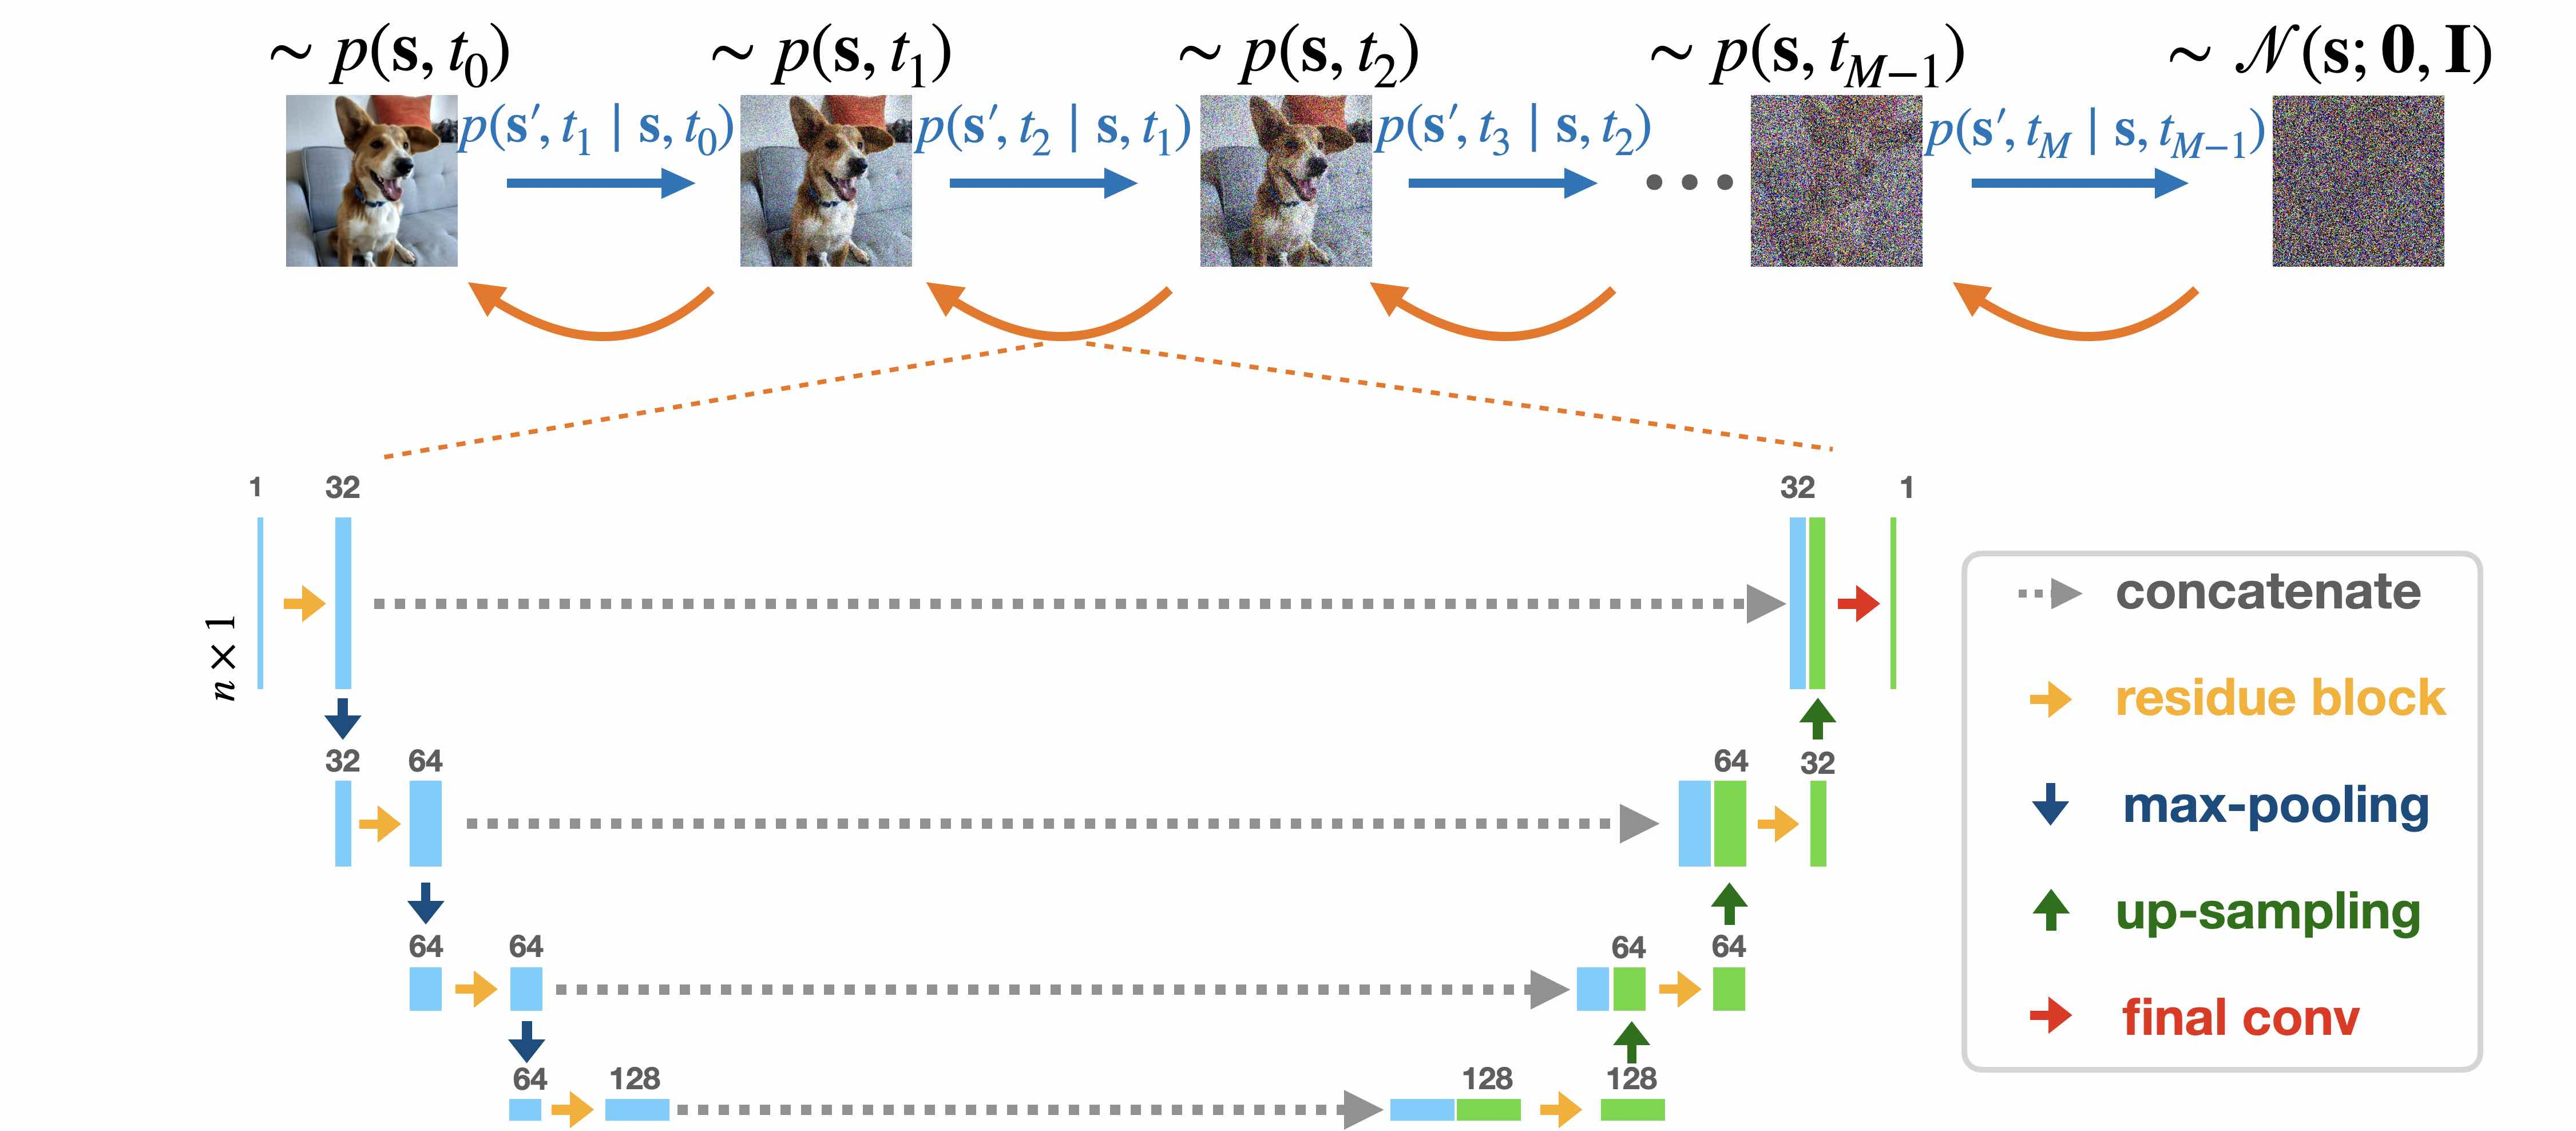

In [1]:
import math
import copy
import torch
from torch import nn, einsum
import torch.nn.functional as F
from inspect import isfunction
from functools import partial

from torch.utils import data
from pathlib import Path
from torch.optim import Adam

import numpy as np
from tqdm import tqdm
from einops import rearrange


try:
    from apex import amp
    APEX_AVAILABLE = True
except:
    APEX_AVAILABLE = False

# constants
SAVE_AND_SAMPLE_EVERY = 25000
UPDATE_EMA_EVERY = 10
PRINT_LOSS_EVERY = 200

#MODEL_INFO= '128-1-2-2-4-b128'
# helpers functions

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def cycle(dl):
    while True:
        for data in dl:
            yield data

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def generate_inprint_mask(n_batch, op_num, unmask_index = None):
    '''
    The mask will be True where we keep the true value and false where we want to infer the value
    So far it only supporting masking the right side of images

    '''
    mask = torch.zeros((n_batch, 1, op_num), dtype = bool)
    if not unmask_index == None:
        mask[:,:, unmask_index] = True
    return mask

def loss_backwards(fp16, loss, optimizer, **kwargs):
    if fp16:
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward(**kwargs)
    else:
        loss.backward(**kwargs)

# small helper modules

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Rezero(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        self.g = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return self.fn(x) * self.g

# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(dim, dim_out, 3, padding=1),
            nn.GroupNorm(groups, dim_out),
            Mish()
        )
    def forward(self, x):
        return self.block(x)

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            Mish(),
            nn.Linear(time_emb_dim, dim_out)
        )

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv1d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb):
        h = self.block1(x)
        h += self.mlp(time_emb)[:, :, None]
        
        h = self.block2(h)
        return h + self.res_conv(x)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv1d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv1d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, l = x.shape
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b (qkv heads c) l -> qkv b heads c l', heads = self.heads, qkv=3)
        k = k.softmax(dim=-1)
        context = torch.einsum('bhdn,bhen->bhde', k, v)
        out = torch.einsum('bhde,bhdn->bhen', context, q)
        out = rearrange(out, 'b heads c l -> b (heads c) l', heads=self.heads)
        return self.to_out(out)

# model

class Unet(nn.Module):
    def __init__(self, dim, out_dim = None, dim_mults=(1, 2, 4, 8), groups = 8):
        super().__init__()
        dims = [1, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        self.feature_dim = dim
        self.dim_mults = dim_mults
        self.time_pos_emb = SinusoidalPosEmb(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            Mish(),
            nn.Linear(dim * 4, dim)
        )

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                ResnetBlock(dim_in, dim_out, time_emb_dim = dim, groups = groups),
                ResnetBlock(dim_out, dim_out, time_emb_dim = dim, groups = groups),
                Residual(Rezero(LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else nn.Identity()
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(mid_dim, mid_dim, time_emb_dim = dim, groups = groups)
        self.mid_attn = Residual(Rezero(LinearAttention(mid_dim)))
        self.mid_block2 = ResnetBlock(mid_dim, mid_dim, time_emb_dim = dim, groups = groups)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(nn.ModuleList([
                ResnetBlock(dim_out * 2, dim_in, time_emb_dim = dim, groups = groups),
                ResnetBlock(dim_in, dim_in, time_emb_dim = dim, groups = groups),
                Residual(Rezero(LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else nn.Identity()
            ]))

        out_dim = default(out_dim, 1)
        self.final_conv = nn.Sequential(
            Block(dim, dim, groups = groups),
            nn.Conv1d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        t = self.time_pos_emb(time)
        t = self.mlp(t)

        h = []
        size_list = []

        for resnet, resnet2, attn, downsample in self.downs:
            x = resnet(x, t)
            x = resnet2(x, t)
            x = attn(x)
            h.append(x)
            size_list.append(x.shape[-1])
            x = downsample(x)
           

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)
      
        for resnet, resnet2, attn, upsample in self.ups:        
            x = torch.cat((x[:,:,:size_list.pop()], h.pop()), dim=1)
            x = resnet(x, t)
            x = resnet2(x, t)
            x = attn(x)
            x = upsample(x)
            
        return self.final_conv(x[:,:,:size_list.pop()])

# gaussian diffusion trainer class

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(shape[0], *((1,) * (len(shape) - 1)))
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()

def linear_schedule(timesteps, s = 0.008):
    """
    linear schedule
    """
    betas = np.linspace(0.0001, 0.02, timesteps, dtype=np.float64)
    return np.clip(betas, a_min = 0, a_max = 0.999)

class GaussianDiffusion(nn.Module):
    def __init__(self, denoise_fn, timesteps=1000, loss_type='l1', betas = None, unmask_number = 0):
        super().__init__()
        self.denoise_fn = denoise_fn

        if exists(betas):
            betas = betas.detach().cpu().numpy() if isinstance(betas, torch.Tensor) else betas
        else:
            betas = linear_schedule(timesteps)

        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.loss_type = loss_type
        self.unmask_number = unmask_number
        if unmask_number == 0:
            self.unmask_index = None
        else:
            self.unmask_index = [*range(unmask_number)]
            

        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod', to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod', to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer('posterior_variance', to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

    def q_mean_variance(self, x_start, t):
        mean = extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = extract(1. - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, clip_denoised: bool):
        x_recon = self.predict_start_from_noise(x, t=t, noise=self.denoise_fn(x, t))

        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, repeat_noise=False):
        b, _, l, device = *x.shape, x.device
        model_mean, _, model_log_variance = self.p_mean_variance(x=x, t=t, clip_denoised=clip_denoised)
        noise = noise_like(x.shape, device, repeat_noise)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
              
        denosied_x = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        inprint_mask = generate_inprint_mask(b, l, self.unmask_index).to(device)
                
        denosied_x[inprint_mask] = x[inprint_mask]
      
        return denosied_x

    @torch.no_grad()
    def p_sample_loop(self, shape, samples = None):
        device = self.betas.device

        b = shape[0]
        state = torch.randn(shape, device=device)
        
        if not samples == None:
            assert shape == samples.shape
          
            inprint_mask = generate_inprint_mask(b, shape[2], self.unmask_index).to(device)
            state[inprint_mask] = samples[inprint_mask]
          
        for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
            state = self.p_sample(state, torch.full((b,), i, device=device, dtype=torch.long))
        return state

    @torch.no_grad()
    def sample(self, op_number, batch_size = 16, samples = None):
        return self.p_sample_loop((batch_size, 1, op_number), samples)


    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        
        x_noisy = extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start + extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise

        if not self.unmask_index == None:
            b, c, l=x_start.shape
            inprint_mask = generate_inprint_mask(b, l, self.unmask_index).to(x_start.device)
            x_start[inprint_mask]
            x_noisy[inprint_mask] = x_start[inprint_mask]
        else:
            inprint_mask = None
        return x_noisy, inprint_mask

    def p_losses(self, x_start, t, noise = None):
        b, c, l= x_start.shape
        noise = default(noise, lambda: torch.randn_like(x_start))

        x_noisy, inprint_mask = self.q_sample(x_start=x_start, t=t, noise=noise)
        
        x_recon = self.denoise_fn(x_noisy, t)
        
        
        if not inprint_mask == None:
            noise = torch.masked_select( noise, ~inprint_mask )
            x_recon = torch.masked_select( x_recon, ~inprint_mask )
            
            
        if self.loss_type == 'l1':
            loss = (noise - x_recon).abs().mean()
        elif self.loss_type == 'l2':
            loss = F.mse_loss(noise, x_recon)
        else:
            raise NotImplementedError()

        return loss

    def forward(self, x, *args, **kwargs):
        b, *_, device = *x.shape, x.device
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()
        return self.p_losses(x, t, *args, **kwargs)

# dataset classes

class Dataset_traj(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, folder, system):
        super().__init__()
        self.folder = folder
        #self.paths = [p for p in Path(f'{folder}').glob(f'**/{system}_traj*.npy')]
        self.data = np.load(f'{folder}/{system}_traj.npy')
        self.max_data = np.max(self.data, axis = 0)
        self.min_data = np.min(self.data, axis = 0)
     

  def __len__(self):
        'Denotes the total number of samples'
        return np.shape(self.data)[0] 

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x = self.data[index:index+1, :]
        x = 2*x/(self.max_data - self.min_data)
        x = x - 2*self.min_data/(self.max_data-self.min_data) -1
        #x = x[ np.newaxis, ...]
        return torch.from_numpy(x).float()

# trainer class

class Trainer(object):
    def __init__(
        self,
        diffusion_model,
        folder,
        system,
        *,
        system_for_sample = None,
        ema_decay = 0.995,
        op_number = 4,
        train_batch_size = 32,
        sample_batch_size = None,
        train_lr = 2e-5,
        train_num_steps = 100000,
        gradient_accumulate_every = 2,
        fp16 = False,
        step_start_ema = 2000
    ):
        super().__init__()
        
        feature_dim = diffusion_model.denoise_fn.module.feature_dim 
        dim_mults = diffusion_model.denoise_fn.module.dim_mults
        MODEL_INFO = f'{feature_dim }-'
        for w in dim_mults :
            MODEL_INFO +=  f'{w}-' 
        MODEL_INFO  += f'b{train_batch_size}'
        
        self.RESULTS_FOLDER = Path(f'./results/{system}/{MODEL_INFO}/given_{diffusion_model.unmask_number-1}_op')
        self.RESULTS_FOLDER.mkdir(exist_ok = True, parents=True)
        self.model = diffusion_model
        self.ema = EMA(ema_decay)
        self.ema_model = copy.deepcopy(self.model)
        self.step_start_ema = step_start_ema
    
        self.batch_size = train_batch_size
        self.op_number =  op_number +1 
        self.gradient_accumulate_every = gradient_accumulate_every
        self.train_num_steps = train_num_steps

        self.ds = Dataset_traj(folder, system )
        self.dl = cycle(data.DataLoader(self.ds, batch_size = train_batch_size, shuffle=True, pin_memory=True))
        
        self.sample_batch_size = train_batch_size
        if system_for_sample == None:
            self.dl_sample= self.dl
        else:
            self.ds_sample = Dataset_traj(folder, system_for_sample )
            if sample_batch_size == None:
                self.sample_batch_size = train_batch_size
            self.dl_sample = cycle(data.DataLoader(self.ds_sample, batch_size = sample_batch_size, shuffle=True, pin_memory=True))
            
        self.opt = Adam(diffusion_model.parameters(), lr=train_lr)

        self.step = 0

        assert not fp16 or fp16 and APEX_AVAILABLE, 'Apex must be installed in order for mixed precision training to be turned on'

        self.fp16 = fp16
        if fp16:
            (self.model, self.ema_model), self.opt = amp.initialize([self.model, self.ema_model], self.opt, opt_level='O1')

        self.reset_parameters()

    def reset_parameters(self):
        self.ema_model.load_state_dict(self.model.state_dict())

    def step_ema(self):
        if self.step < self.step_start_ema:
            self.reset_parameters()
            return
        self.ema.update_model_average(self.ema_model, self.model)

    def save(self, milestone):
        data = {
            'step': self.step,
            'model': self.model.state_dict(),
            'ema': self.ema_model.state_dict(),
            'data_range': [self.ds.min_data, self.ds.max_data]
        }
        torch.save(data, str(self.RESULTS_FOLDER /  f'model-{milestone}.pt'))
        
        
    def rescale_sample_back(self, sample):   
        
        def scale_back(data, minimums, maximums):
            data = (data + 1)/2.0*(maximums - minimums)
            data += minimums
            return data
        
        max_data = self.ds.max_data
        min_data = self.ds.min_data
        
        sample = scale_back(sample, min_data, max_data)
    
        return sample

    def load(self, milestone):
        model_data = torch.load(str(self.RESULTS_FOLDER / f'model-{milestone}.pt'),map_location=torch.device("cpu"))

        self.step =  model_data['step']
        self.model.load_state_dict( model_data['model'])
        self.ema_model.load_state_dict( model_data['ema'])
        self.ds.min_data = model_data['data_range'][0]
        self.ds.max_data = model_data['data_range'][1]
        self.dl = cycle(data.DataLoader(self.ds, batch_size = self.batch_size, shuffle=True, pin_memory=True))

    def train(self):
        backwards = partial(loss_backwards, self.fp16)
        
        while self.step < self.train_num_steps:
            for i in range(self.gradient_accumulate_every):
                data = next(self.dl).cuda()
                loss = self.model(data)
                backwards(loss / self.gradient_accumulate_every, self.opt)

            self.opt.step()
            self.opt.zero_grad()

            if self.step % UPDATE_EMA_EVERY == 0:
                self.step_ema()
                
            if self.step % PRINT_LOSS_EVERY ==0:
                print(f'{self.step}: {loss.item()}')
                

            if self.step != 0 and self.step % SAVE_AND_SAMPLE_EVERY == 0:
                milestone = self.step // SAVE_AND_SAMPLE_EVERY
                batches = num_to_groups(self.sample_batch_size, self.batch_size)
                all_ops_list = list(map(lambda n: self.ema_model.sample(self.op_number, batch_size=n, samples = next(self.dl_sample).cuda()[:n, :]), batches))
                all_ops = torch.cat(all_ops_list, dim=0).cpu()
                all_ops = self.rescale_sample_back(all_ops)
                np.save( str(self.RESULTS_FOLDER /  f'sample-{milestone}'), all_ops.numpy())
                self.save(milestone)

            self.step += 1

        print('training completed')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from torch import nn 

device = torch.device("cpu")

# define the U-net structure
model = Unet(
    dim = 32,                   
    dim_mults = (1, 2, 2, 4 ),   
    groups = 8
).to(device) 
model = nn.DataParallel(model)
model.to(torch.device("cpu"))

# define diffusion model
op_num = 18  
konw_op_num = 0
diffusion = GaussianDiffusion(
    model,                        # U-net model
    timesteps = 1000,             # number of diffusion steps
    unmask_number=konw_op_num+1,  # the dimension of x2 in P(x1|x2)
    loss_type = 'l2'              # L1 or L2
).to(torch.device("cpu"))

#set training parameters
trainer = Trainer(
    diffusion,                                   # diffusion model
     folder = 'traj_AIB9',                        # folder of trajectories
    system = 'AIB9_REMD_T_full_100000ps_2.0ps',  # name of the trajectory, the file {system}_traj.npy will be used as the training set
    train_batch_size = 128,                      # training batch size
    train_lr = 1e-5,                             # learning rate
    train_num_steps = 2000000,                   # total training steps
    gradient_accumulate_every = 1,               # gradient accumulation steps
    ema_decay = 0.995,                           # exponential moving average decay
    op_number = op_num,
    fp16 = False                               # turn on mixed precision training with apex
)

# load trained model
model_id = 30 
trainer.load(model_id) 
# start training
#trainer.train()

#**Generate samples**

To generate samples from distribtuion $P(x_1 |x_2)$, we need to provide samples about the conditional part $x_2$. 

In this example, it is relatively simple as we only need to privde the information about the temperature. 

In [3]:
#prepare a dataloader to give samples from the conditional part of the distribution
batch_size = 1280  #the number of samples generated in each batch
sample_ds = Dataset_traj('traj_AIB9', 'sample_T') 
sample_ds.max_data = trainer.ds.max_data
sample_ds.min_data = trainer.ds.min_data        #To ensure that the sample data is scaled in the same way as the training data
sample_dl = cycle(data.DataLoader(sample_ds, batch_size = batch_size, shuffle=True, pin_memory=True)) 

T_sample = np.load('traj_AIB9/sample_T_traj.npy')
print(T_sample)

[[400.]
 [400.]
 [400.]
 ...
 [400.]
 [400.]
 [400.]]


In [5]:
num_sample = 2000 #total number of samples
model_id = 30
trainer.load(model_id) 

batches = num_to_groups(num_sample, batch_size)
all_ops_list = list(map(lambda n: trainer.ema_model.sample(trainer.op_number, batch_size=n, samples = next(sample_dl)[:n, :]), batches))
all_ops = torch.cat(all_ops_list, dim=0).cpu()
all_ops = trainer.rescale_sample_back(all_ops)
np.save(str(trainer.RESULTS_FOLDER / f'samples-{model_id}'), all_ops.numpy())
print(str(trainer.RESULTS_FOLDER / f'samples-{model_id}.npy'))

sampling loop time step: 100%|██████████| 1000/1000 [08:26<00:00,  1.97it/s]

results/AIB9_REMD_T_full_100000ps_2.0ps/32-1-2-2-4-b128/given_0_op/samples-30.npy


#**Result Analysis**

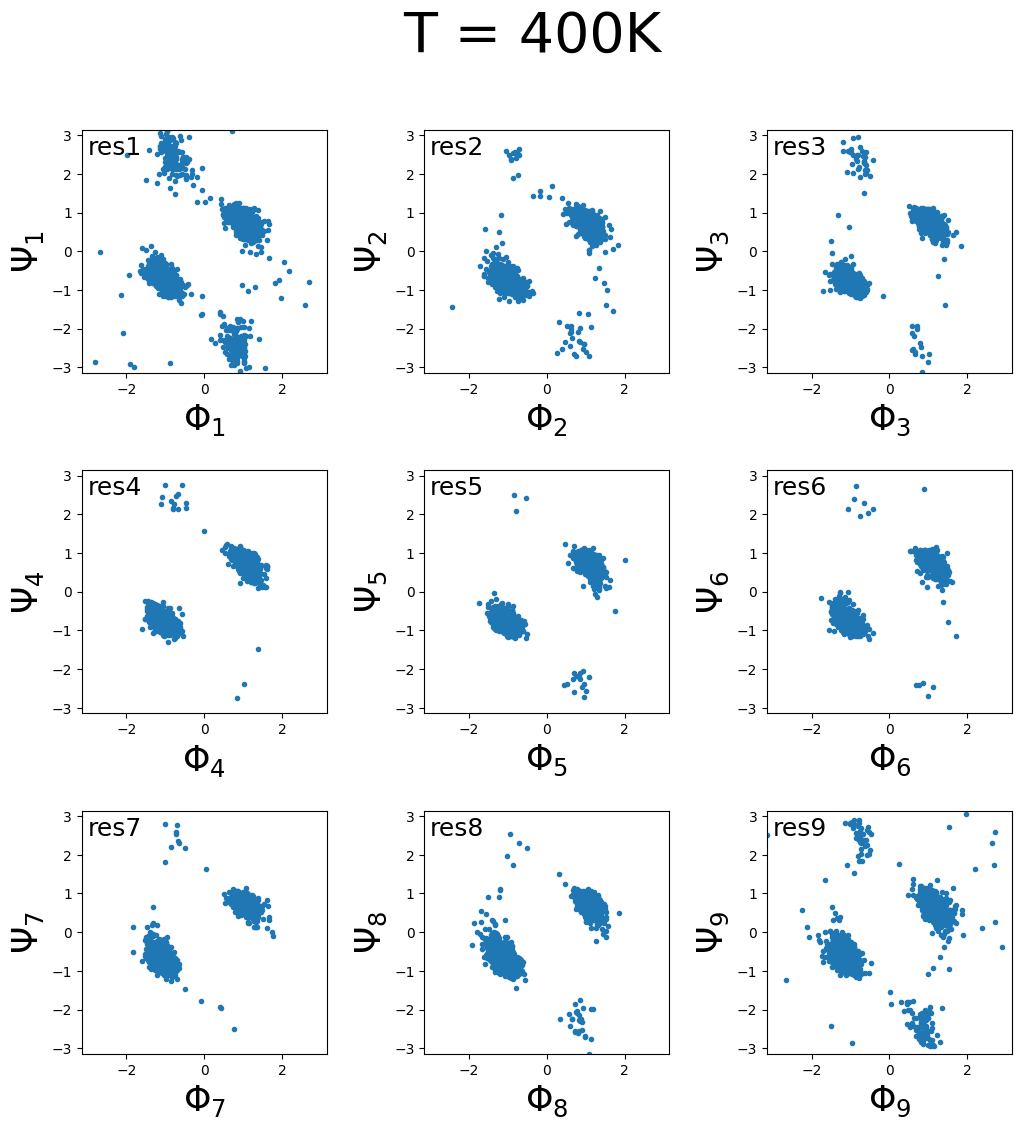

In [9]:
import matplotlib.pyplot as plt
# plt samples generated from the model with T=400
samples = np.load('results/AIB9_REMD_T_full_100000ps_2.0ps/32-1-2-2-4-b128/given_0_op/samples-30.npy')
fig = plt.figure(figsize=(12, 12),frameon=False)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('T = 400K', fontsize=40)
for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i)
    ax.plot(samples[:,0, i*2-1], samples[:,0, i*2],'.')    
    ax.text(-3, 2.5,  f'res{i}', fontsize = 18)
    ax.set_xlim([-np.pi, np.pi])
    ax.set_ylim([-np.pi, np.pi])
    ax.set_xlabel(r'$\Phi_%i$'%i, fontsize = 25)
    ax.set_ylabel(r'$\Psi_%i$'%i, fontsize = 25)